# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests

import OncoMark as oma
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/var/folders/tf/0py1zbcx6g5_r9bpq5dw4f6h0000gn/T/ipykernel_27061/503042030.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2024-02-21 19:00:56|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

# Copy number variation of KIR3DL2

In [3]:
focal_cnv = pd.read_csv("../OncoMark/data/datasets/KIR3DL2_alterations_across_samples.tsv", sep="\t")
patient_meta_cBio = pd.read_csv("../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv", sep="\t")
patient_meta_cBio = patient_meta_cBio[["Patient ID","TCGA PanCanAtlas Cancer Type Acronym"]].drop_duplicates().set_index(['Patient ID'])
focal_cnv["TCGA_project"] = focal_cnv["Patient ID"].map(patient_meta_cBio['TCGA PanCanAtlas Cancer Type Acronym'])
focal_cnv["KIR3DL2: AMP"] = focal_cnv["KIR3DL2: AMP"] == "AMP"
focal_cnv["KIR3DL2: HOMEDEL"] = focal_cnv["KIR3DL2: HOMDEL"] == "HOMDEL"
focal_cnv_amp_rate = focal_cnv.groupby("TCGA_project").sum()[["KIR3DL2: AMP"]] / focal_cnv.groupby("TCGA_project").count()[["KIR3DL2: AMP"]]
focal_cnv_del_rate = focal_cnv.groupby("TCGA_project").sum()[["KIR3DL2: HOMEDEL"]] / focal_cnv.groupby("TCGA_project").count()[["KIR3DL2: HOMEDEL"]]

In [4]:
CNV_rate = focal_cnv_amp_rate.join(focal_cnv_del_rate) * 100
CNV_rate = CNV_rate.reindex(['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC'])
CNV_rate.columns= ["Amplification", "Deletion"]
CNV_rate = CNV_rate[~CNV_rate.index.isin(["DLBC", "LAML"])]
CNV_rate =  CNV_rate.loc[CNV_rate[["Amplification", "Deletion"]].sum(axis=1).sort_values(ascending=False).index]
CNV_rate.head()

,Amplification,Deletion
TCGA_project,,
LGG,0.194553,3.501946
BLCA,3.163017,0.000000
ESCA,1.098901,1.098901
OV,1.880342,0.000000
BRCA,1.660517,0.092251


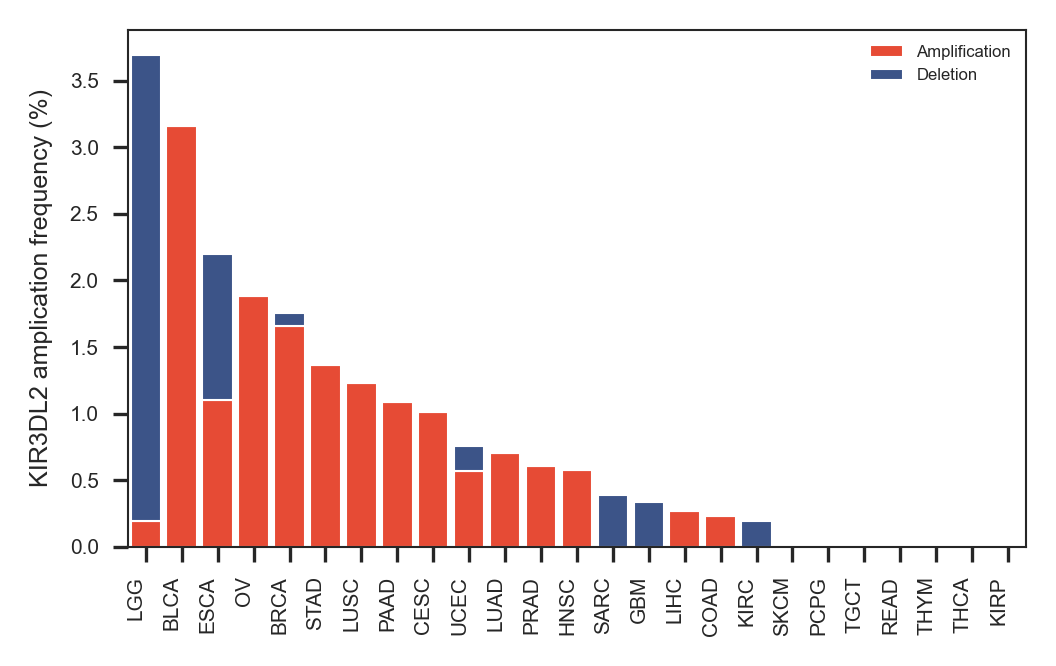

In [5]:
cmap = oma.pl.cmap()
width = .85

fig, ax = plt.subplots(figsize = (3.5, 2.2))
bottom = np.zeros(CNV_rate.shape[0])

for col, color in zip(CNV_rate.columns, [cmap.npg_palette(0), cmap.npg_palette(3)]):
    p = ax.bar(CNV_rate.index, CNV_rate[col], width, label=col, bottom=bottom, color=color, linewidth=.5)
    bottom += CNV_rate[col].values
ax.set_xlim(-0.5, CNV_rate.shape[0]-.5)
ax.set_ylim(0., CNV_rate.sum(axis=1).max()*1.05)
ax.legend(loc="upper right", frameon=False)
ax.set(xlabel="", ylabel="KIR3DL2 amplication frequency (%)");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.savefig("../figures/FigS3G.pdf", bbox_inches = "tight")

# Expression of KIR3DL2 in tumor vs Normal

In [6]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=100, sample_type="Tumor", genes=["KIR3DL2"])
KIR3DL2_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","subtype", "samples.sample_type"]])

patient_data_TCGA_normal = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                              metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                              filter_samples=10, sample_type="Normal", genes=["KIR3DL2"])
KIR3DL2_normal = patient_data_TCGA_normal.to_df().join(patient_data_TCGA_normal.obs[["project_id","subtype", "samples.sample_type"]])

KIR3DL2 = pd.concat([KIR3DL2_tumor, KIR3DL2_normal])
KIR3DL2 = KIR3DL2[~KIR3DL2['project_id'].isin(['LAML', "DLBC"])]

2024-02-21 19:00:57|INFO|dataloader|Dropping duplicates...
2024-02-21 19:00:57|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-21 19:00:57|INFO|dataloader|Take Tumor samples only.
2024-02-21 19:00:57|INFO|dataloader|Take gene expression data of ['KIR3DL2']
2024-02-21 19:00:57|INFO|dataloader|Filtering out patients with < 100 samples...
2024-02-21 19:00:57|INFO|dataloader|Dropping duplicates...
2024-02-21 19:00:57|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-21 19:00:57|INFO|dataloader|Take Normal samples only.
2024-02-21 19:00:57|INFO|dataloader|Take gene expression data of ['KIR3DL2']
2024-02-21 19:00:57|INFO|dataloader|Filtering out patients with < 10 samples...


In [7]:
KIR3DL2 = KIR3DL2.query('subtype!="BRCA_Normal"')
KIR3DL2['sample_type'] = KIR3DL2['samples.sample_type'].map({"Solid Tissue Normal": "Normal"}).fillna("Tumor")
KIR3DL2['Xlabel'] = KIR3DL2['project_id'].copy()
KIR3DL2 = KIR3DL2[KIR3DL2['Xlabel'].notna()]
KIR3DL2["Xlabel"] = KIR3DL2["Xlabel"].str.replace("_", "-")
KIR3DL2['xtick'] = [str(v[0]) + "." + str(v[1]) for v in KIR3DL2[["Xlabel", "sample_type"]].values]

In [8]:
results = pd.DataFrame(index=KIR3DL2['Xlabel'].unique(), columns=["tstat", "pval", "median1", "median2", "sample_size1", "sample_size2", "diff_med"])

for pid in KIR3DL2['Xlabel'].unique():
    subset = KIR3DL2.query('Xlabel==@pid')
    tstat_res = oma.tl.t_test(subset, groupby='sample_type', group1='Tumor', group2='Normal', value='KIR3DL2')
    results.loc[pid, "tstat"] = float(tstat_res[0])
    results.loc[pid, "pval"] = float(tstat_res[1])
    results.loc[pid, "median1"] = float(tstat_res[4][0])
    results.loc[pid, "median2"] = float(tstat_res[4][1])
    results.loc[pid, "sample_size1"] = int(tstat_res[5][0])
    results.loc[pid, "sample_size2"] = int(tstat_res[5][1])
    results.loc[pid, "diff_med"] = float(tstat_res[4][0]) - float(tstat_res[4][1])
    
results = results[results.index.notna()]
results = results.drop(index=["KICH"])
results['stars'] = [oma.pl.pval2star(p, keep_pval=False) for p in results['pval']]

/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/caibin/miniconda3/envs/IGSF8/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [9]:
results = results.loc[['UCEC', 'PRAD', 'THCA', 'BRCA', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'LGG', 'OV', 'PCPG', 'GBM',
       'TGCT', 'PAAD', 'THYM', 'CESC', 'SARC', 'KIRP', 'KIRC']]

In [10]:
# Convert the column to the Categorical data type with the custom order
KIR3DL2['Xlabel'] = pd.Categorical(KIR3DL2['Xlabel'], categories=results.index.tolist(), ordered=True)
KIR3DL2['sample_type'] = pd.Categorical(KIR3DL2['sample_type'], categories=["Tumor", "Normal"], ordered=True)
# Sort the DataFrame by the custom-ordered column
KIR3DL2 = KIR3DL2.sort_values(["Xlabel", "sample_type"]).dropna()

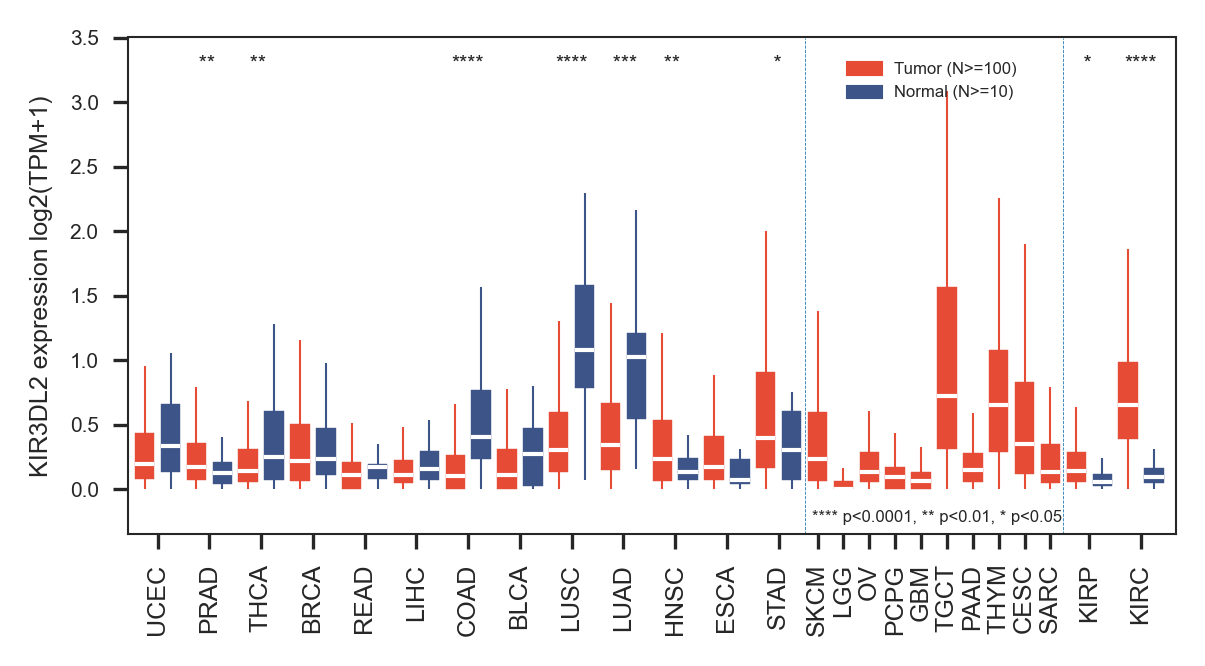

In [11]:
plt.figure(figsize=(4, 2.2))

color = [cmap.npg_palette(3) if x.endswith('Normal') else cmap.npg_palette(0) for x in KIR3DL2['xtick'].unique()]

ax = sns.boxplot(data=KIR3DL2, 
                 x='xtick',
                 y='KIR3DL2', 
                 palette=color, 
                 showfliers = False,
                 showcaps=False,
                 saturation=1,
                 # dodge=True,
                 width=0.75,
                 # **PROPS
                  );

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.patches.PathPatch:
        c.set_edgecolor(color[i])
        c.set_linewidth(0.1)
        i+=1

i = 0
for c in ax.get_children():
    if type(c) == matplotlib.lines.Line2D:        
        [c.set_linewidth(1.) if i%3==2 else c.set_linewidth(0.5)]
        if i%3==2:
            c.set_color('white')
        else:
            c.set_color(color[i//3])
        i+=1

for i, ticklabel in enumerate(ax.xaxis.get_ticklabels()):
    if ticklabel.get_text().split('.')[1]=='Normal':
        ax.text(ticklabel.get_position()[0]-1.15, 3.25, results.loc[ticklabel.get_text().split(".")[0], 'stars'],  fontsize=5) #color=cmap.Vermilion, rotation='vertical', 
        
xlim = ax.get_xlim()
xticks = [x.split(".")[0] for x in KIR3DL2['xtick'].unique()]
Xtick_tmp = pd.DataFrame([ax.get_xticks(), xticks]).T
Xtick_tmp.columns=['xticks', 'tumor']
Xtick_tmp = Xtick_tmp.groupby('tumor').mean().sort_values('xticks')

ax.set(xlabel='', ylim=(-.35, 3.5), xlim=(-.65, xlim[1]+.35));
ax.set_xticks(Xtick_tmp['xticks'].astype(float).values, labels=Xtick_tmp.index.to_list());
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center', fontsize=6);
ax.set_ylabel('KIR3DL2 expression log2(TPM+1)', fontsize=6)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=5);

ax.vlines(25.5, -.35, 3.5, ls='--', lw=0.2)
ax.vlines(35.5, -.35, 3.5, ls='--', lw=0.2)

from matplotlib.patches import Patch
handles = [
    Patch(edgecolor=fc, facecolor=fc, label=label, linewidth=.75) #"white"
    for label, ec, fc in zip(['Tumor (N>=100)', 'Normal (N>=10)'], [cmap.npg_palette(0), cmap.npg_palette(3)], [cmap.npg_palette(0), cmap.npg_palette(3)])
]
ax.legend(handles=handles, loc=(.68, 0.86), ncols=1, fontsize=4., frameon=False);
ax.text(25.8, -.25, '**** p<0.0001, ** p<0.01, * p<0.05', rotation='horizontal', fontsize=4);
plt.savefig("../figures/FigS3F.pdf")

# KIR3DL2 polymorphism

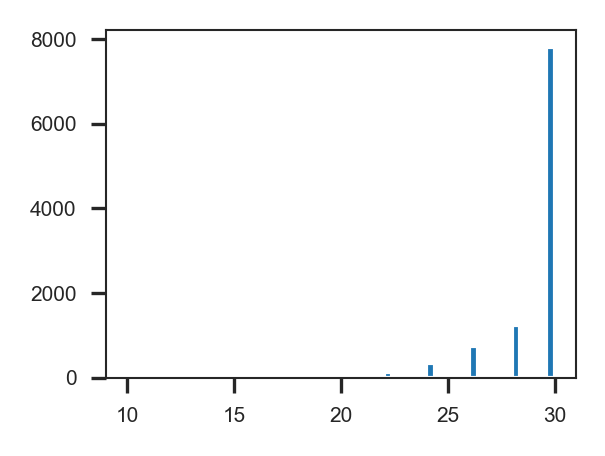

In [13]:
## Download KIRs
# KIRs = pd.read_csv("https://static-content.springer.com/esm/art%3A10.1186%2Fs12915-022-01392-2/MediaObjects/12915_2022_1392_MOESM3_ESM.txt", sep="\t", index_col=0)
# KIRs.to_csv("../OncoMark/data/datasets/KIRs_genotyping_TCGA.csv")

KIRs = pd.read_csv("../OncoMark/data/datasets/KIRs_genotyping_TCGA.csv", index_col=0)

plt.figure(figsize=(2,1.5))
plt.hist(KIRs.sum(axis=1), bins=50);

In [14]:
KIR3DL2 = KIRs.loc[:, KIRs.columns.str.startswith("KIR3DL2")]
KIR3DL2.index = ["-".join(idx.split("-")[:3]) for idx in KIR3DL2.index]
KIR3DL2 = KIR3DL2.stack().to_frame("allele").rename_axis(["submitter_id", "KIR3DL2 allotypes"])
KIR3DL2 = KIR3DL2[KIR3DL2>0].reset_index().dropna().set_index("submitter_id")
KIR3DL2 = KIR3DL2[["KIR3DL2 allotypes"]].reset_index().drop_duplicates().set_index("submitter_id")

In [15]:
frac = KIR3DL2.groupby("KIR3DL2 allotypes").size().sort_values(ascending=False) / KIR3DL2.index.nunique()
frac = frac.to_frame("percentage")
frac["%"] = round(frac*100, 1)
frac["allotypes"] = frac.index.astype(str) + " (" + frac["%"].astype(str) + "%)"

In [16]:
frac.cumsum().head(15).reset_index()

,KIR3DL2 allotypes,percentage,%,allotypes
0,KIR3DL2*010,0.124740,12.5,KIR3DL2*010 (12.5%)
1,KIR3DL2*002,0.246966,24.7,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)
2,KIR3DL2*009,0.347546,34.8,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
3,KIR3DL2*005,0.443971,44.4,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
4,KIR3DL2*107,0.529245,52.9,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
5,KIR3DL2*011,0.612004,61.2,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
6,KIR3DL2*008,0.679239,67.9,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
7,KIR3DL2*001,0.741445,74.1,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
8,KIR3DL2*003,0.801574,80.1,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...
9,KIR3DL2*017,0.846726,84.6,KIR3DL2*010 (12.5%)KIR3DL2*002 (12.2%)KIR3DL2*...


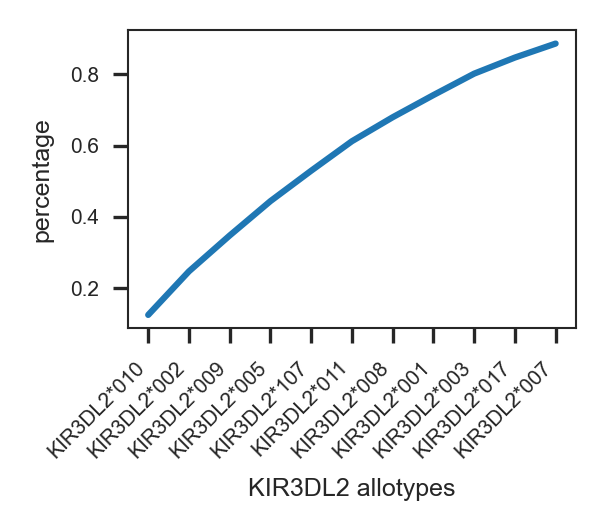

In [17]:
plt.figure(figsize=(2,1.75))
ax = sns.lineplot(data=frac.cumsum().head(11).reset_index(), x="KIR3DL2 allotypes", y="percentage")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [18]:
patient_data_TCGA_tumor = oma.data.load_tcga(filter_samples=100, sample_type="Tumor", genes=["IGSF8", "KIR3DL2"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","submitter_id", "samples.sample_type"]])
IGSF8_tumor = IGSF8_tumor[~IGSF8_tumor['project_id'].isin(['LAML', "DLBC"])].set_index("submitter_id")

KIR3DL2_all_IGSF8 = KIR3DL2.join(IGSF8_tumor).dropna()
KIR3DL2_all_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(frac.index[:11])]
KIR3DL2_all_IGSF8["allotypes"] = KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].map(frac["allotypes"])

2024-02-21 19:00:58|INFO|dataloader|No file path provided. Using the TCGA RNAseq file in the .datasets folder.
2024-02-21 19:00:58|INFO|dataloader|Dropping duplicates...
2024-02-21 19:00:58|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-02-21 19:00:58|INFO|dataloader|Take Tumor samples only.
2024-02-21 19:00:58|INFO|dataloader|Take gene expression data of ['IGSF8', 'KIR3DL2']
2024-02-21 19:00:58|INFO|dataloader|Filtering out patients with < 100 samples...


In [19]:
grouped = KIR3DL2_all_IGSF8.groupby(['KIR3DL2 allotypes'])
tstat_results = pd.DataFrame(index=grouped["KIR3DL2 allotypes"].count().index, columns=["tstat", "pvalue"])
for idx,row in tstat_results.iterrows():
    tstat, p_value = ttest_ind(KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`==@idx')["IGSF8"].values, KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`!=@idx')["IGSF8"].values)
    tstat_results.loc[idx, "tstat"] = tstat
    tstat_results.loc[idx, "pvalue"] = p_value
    
tstat_results.loc[:, "adj.pval"] = multipletests(tstat_results.loc[:, "pvalue"], method='fdr_bh', alpha=0.05)[1]

In [20]:
tstat_results

,tstat,pvalue,adj.pval
KIR3DL2 allotypes,,,
KIR3DL2*001,-1.823726,0.068235,0.375292
KIR3DL2*002,1.190726,0.2338,0.51436
KIR3DL2*003,1.412483,0.157851,0.51436
KIR3DL2*005,0.184971,0.853257,0.853257
KIR3DL2*007,2.266661,0.02344,0.257844
KIR3DL2*008,-0.963459,0.33535,0.614807
KIR3DL2*009,-0.798836,0.424412,0.666933
KIR3DL2*010,0.670651,0.502464,0.690888
KIR3DL2*011,-0.289279,0.772376,0.849614


In [21]:
tstat_results = tstat_results[tstat_results["adj.pval"] < 0.05]

In [22]:
KIR_alllotype = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count()[KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count() > 150].dropna().index
HLA_A_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(KIR_alllotype)]
ordered_KIR_allotypes = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count().sort_values("IGSF8", ascending=False).index

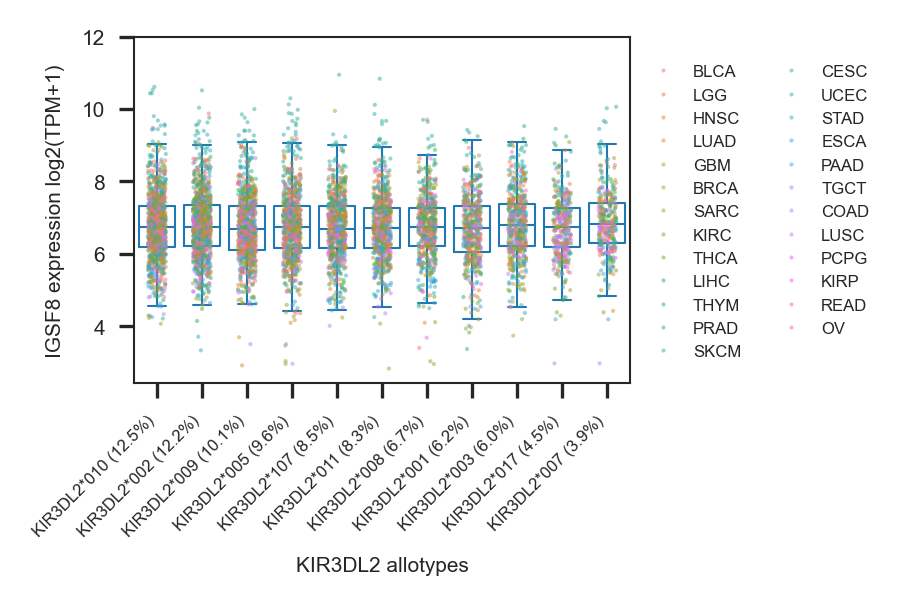

In [23]:
plt.figure(figsize=(3.,2.))
ax = sns.boxplot(data=KIR3DL2_all_IGSF8,
                 x="allotypes",
                 order=frac["allotypes"][:11].values,
                 y="IGSF8",
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 showfliers=False,
                 # hue=""
                )
ax = sns.stripplot(data=KIR3DL2_all_IGSF8,
                   x='allotypes',
                   order=frac["allotypes"][:11].values,
                   y='IGSF8',
                   s=1.,
                   alpha=.5,
                   jitter=.2, hue='project_id',
                  )

ax.set_xlabel("KIR3DL2 allotypes", fontsize=5)
ax.set_ylabel("IGSF8 expression log2(TPM+1)", fontsize=5)
ax.legend(loc=(1.02, .05), ncols=2, fontsize=4, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=4)

for idx,row in tstat_results.iterrows():
    ax.text(list(ordered_KIR_allotypes).index(idx)-.05, 11, oma.pl.pval2star(row["adj.pval"], keep_pval=False), fontsize=4, rotation=90)
ax.set_ylim(None, 12)
plt.savefig("../figures/FigS3T.pdf",  bbox_inches = "tight")

In [24]:
grouped = KIR3DL2_all_IGSF8.groupby(['KIR3DL2 allotypes'])
tstat_results = pd.DataFrame(index=grouped["KIR3DL2 allotypes"].count().index, columns=["tstat", "pvalue"])
for idx,row in tstat_results.iterrows():
    tstat, p_value = ttest_ind(KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`==@idx')["KIR3DL2"].values, KIR3DL2_all_IGSF8.query('`KIR3DL2 allotypes`!=@idx')["KIR3DL2"].values)
    tstat_results.loc[idx, "tstat"] = tstat
    tstat_results.loc[idx, "pvalue"] = p_value
    
tstat_results.loc[:, "adj.pval"] = multipletests(tstat_results.loc[:, "pvalue"], method='fdr_bh', alpha=0.05)[1]

In [25]:
tstat_results = tstat_results[tstat_results["adj.pval"] < 0.05]

In [26]:
KIR_alllotype = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count()[KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count() > 150].dropna().index
HLA_A_IGSF8 = KIR3DL2_all_IGSF8[KIR3DL2_all_IGSF8["KIR3DL2 allotypes"].isin(KIR_alllotype)]
ordered_KIR_allotypes = KIR3DL2_all_IGSF8.groupby("KIR3DL2 allotypes").count().sort_values("KIR3DL2", ascending=False).index

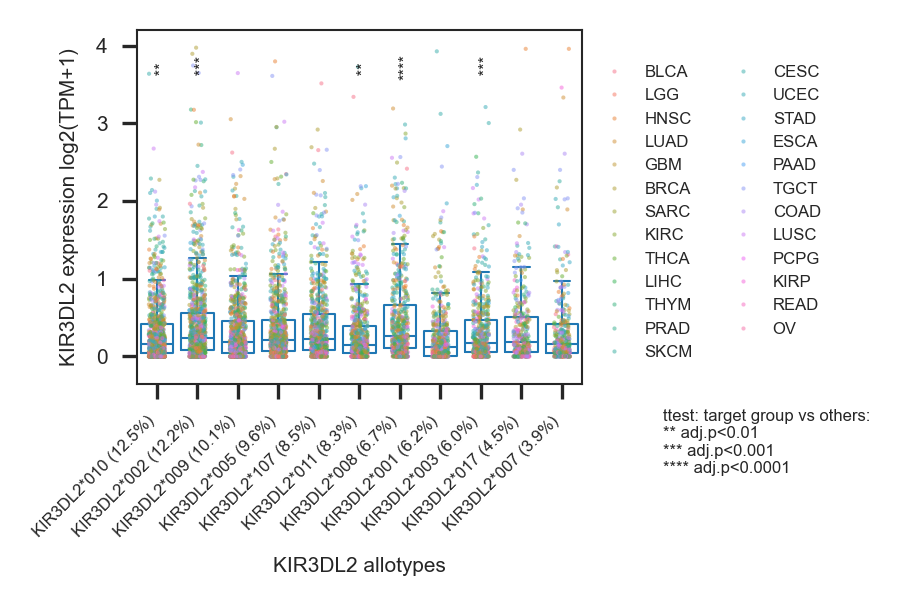

In [27]:
plt.figure(figsize=(3.,2.))
ax = sns.boxplot(data=KIR3DL2_all_IGSF8,
                 x="allotypes",
                 order=frac["allotypes"][:11].values,
                 y="KIR3DL2",
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 showfliers=False
                 # hue=""
                )
ax = sns.stripplot(data=KIR3DL2_all_IGSF8,
                   x='allotypes',
                   order=frac["allotypes"][:11].values,
                   y='KIR3DL2',
                   s=1.,
                   alpha=.5,
                   jitter=.2, hue='project_id',
                  )

ax.set_xlabel("KIR3DL2 allotypes", fontsize=5)
ax.set_ylabel("KIR3DL2 expression log2(TPM+1)", fontsize=5)
ax.legend(loc=(1.02, .05), ncols=2, fontsize=4, frameon=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=4)

for idx,row in tstat_results.iterrows():
    ax.text(list(ordered_KIR_allotypes).index(idx)-.05, 3.6, oma.pl.pval2star(row["adj.pval"], keep_pval=False), fontsize=4, rotation=90)
ax.text(12.5, -1.5, "ttest: target group vs others: \n** adj.p<0.01\n*** adj.p<0.001\n**** adj.p<0.0001", fontsize=4) #***p<0.001\\n****p<0.0001  \n*p<0.05\n
ax.set_ylim(None, 4.2)
plt.savefig("../figures/FigS3S.pdf",  bbox_inches = "tight")